## Churn Prediction in Vertex

In this notebook, we gathered the functions created on the [Churn Prediction Project notebook](02_churn_pred.ipynb) (written by following the third week of the course) and created a Vertex Pipeline to operationalize training. 

The steps followed are:

1. Creating the components (one for each function) [[from Python UDF to KFP component](https://www.kubeflow.org/docs/components/pipelines/v2/components/lightweight-python-components/)].
1. Creating the DAG of the pipeline.
1. Running the pipeline using the Vertex AI SDK [[enablement and code on Google Docs](https://cloud.google.com/vertex-ai/docs/pipelines/run-pipeline#vertex-ai-sdk-for-python)].


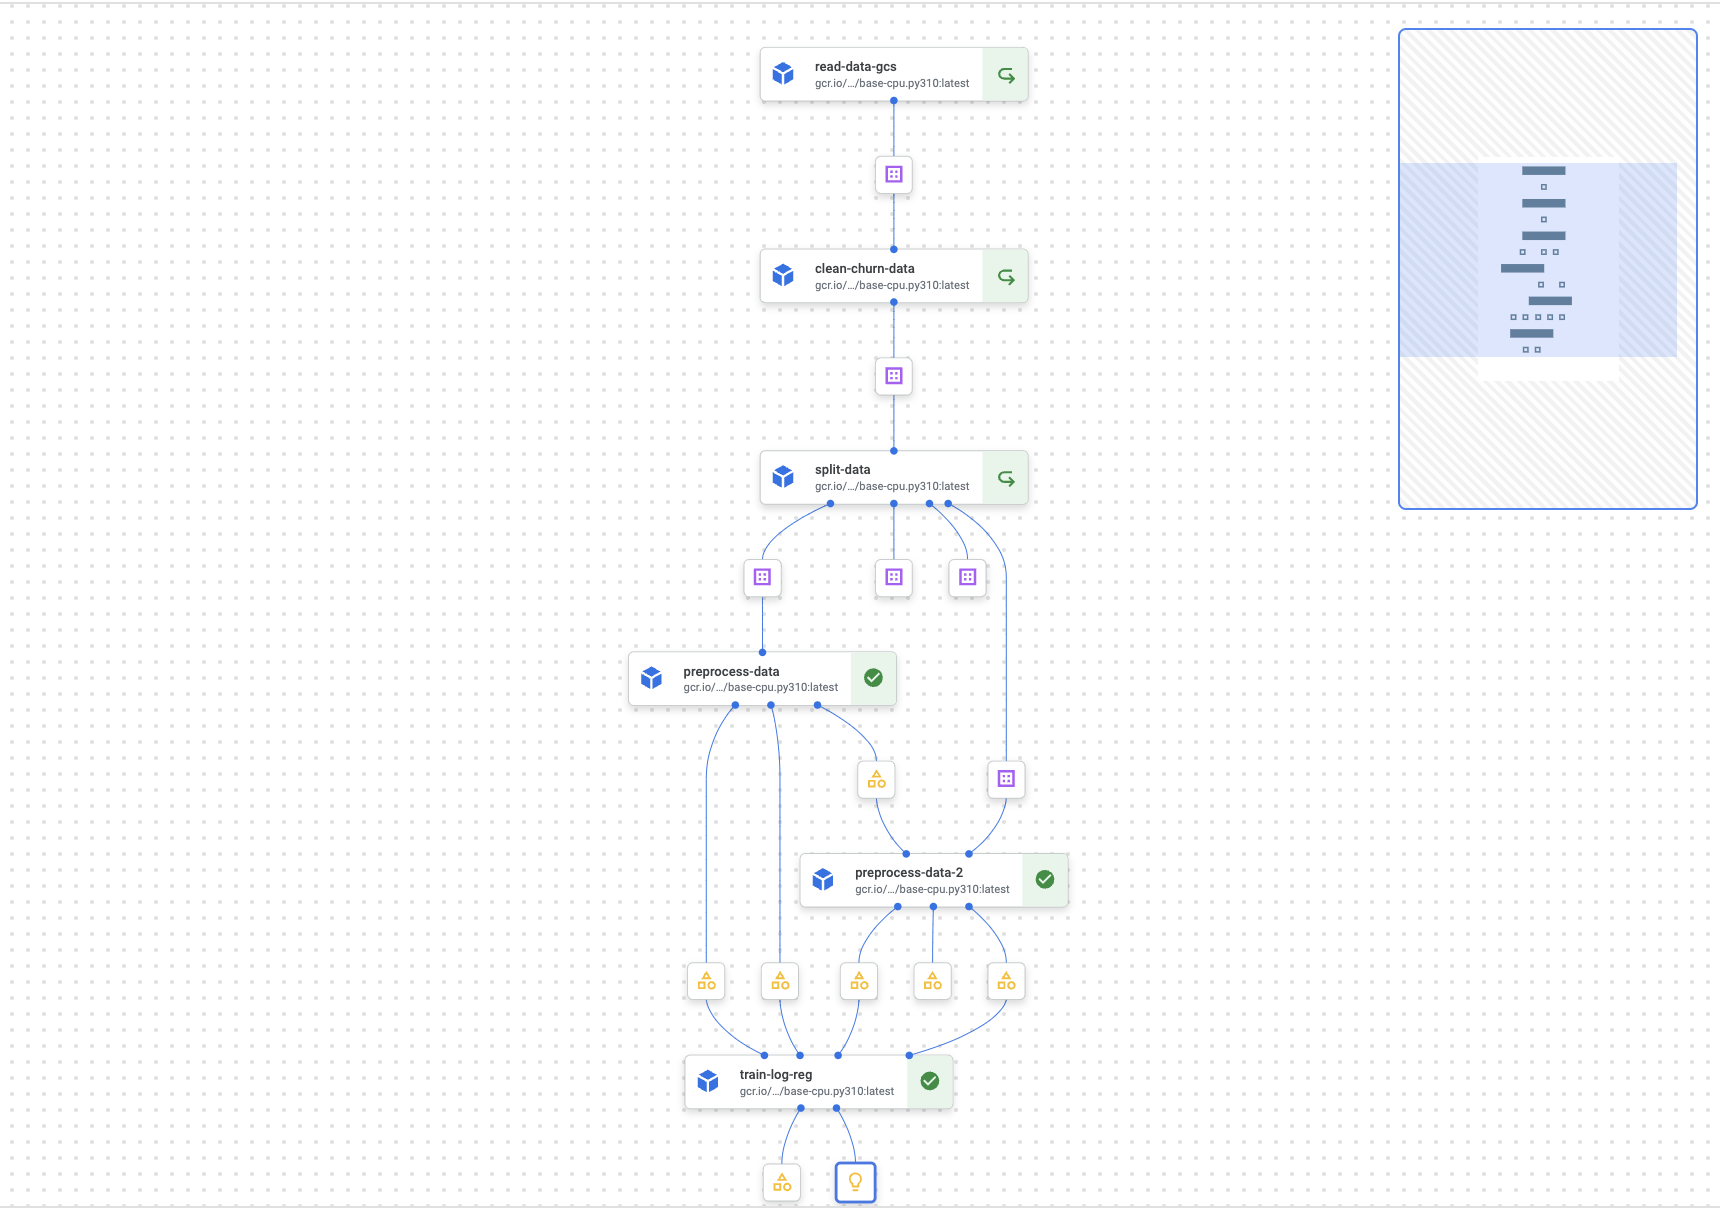

> Artifacts are automatically passed and stored (together with lineage) by Vertex AI. We can find artifacts of the type model (💡), dataset (🔢 in purple), metrics, and generic artifacts (🔼⏹️⏺️ in yellow)[an ex. of a generic artifact is the arrays X, y that generated our model].

Output parameter (accuracy):
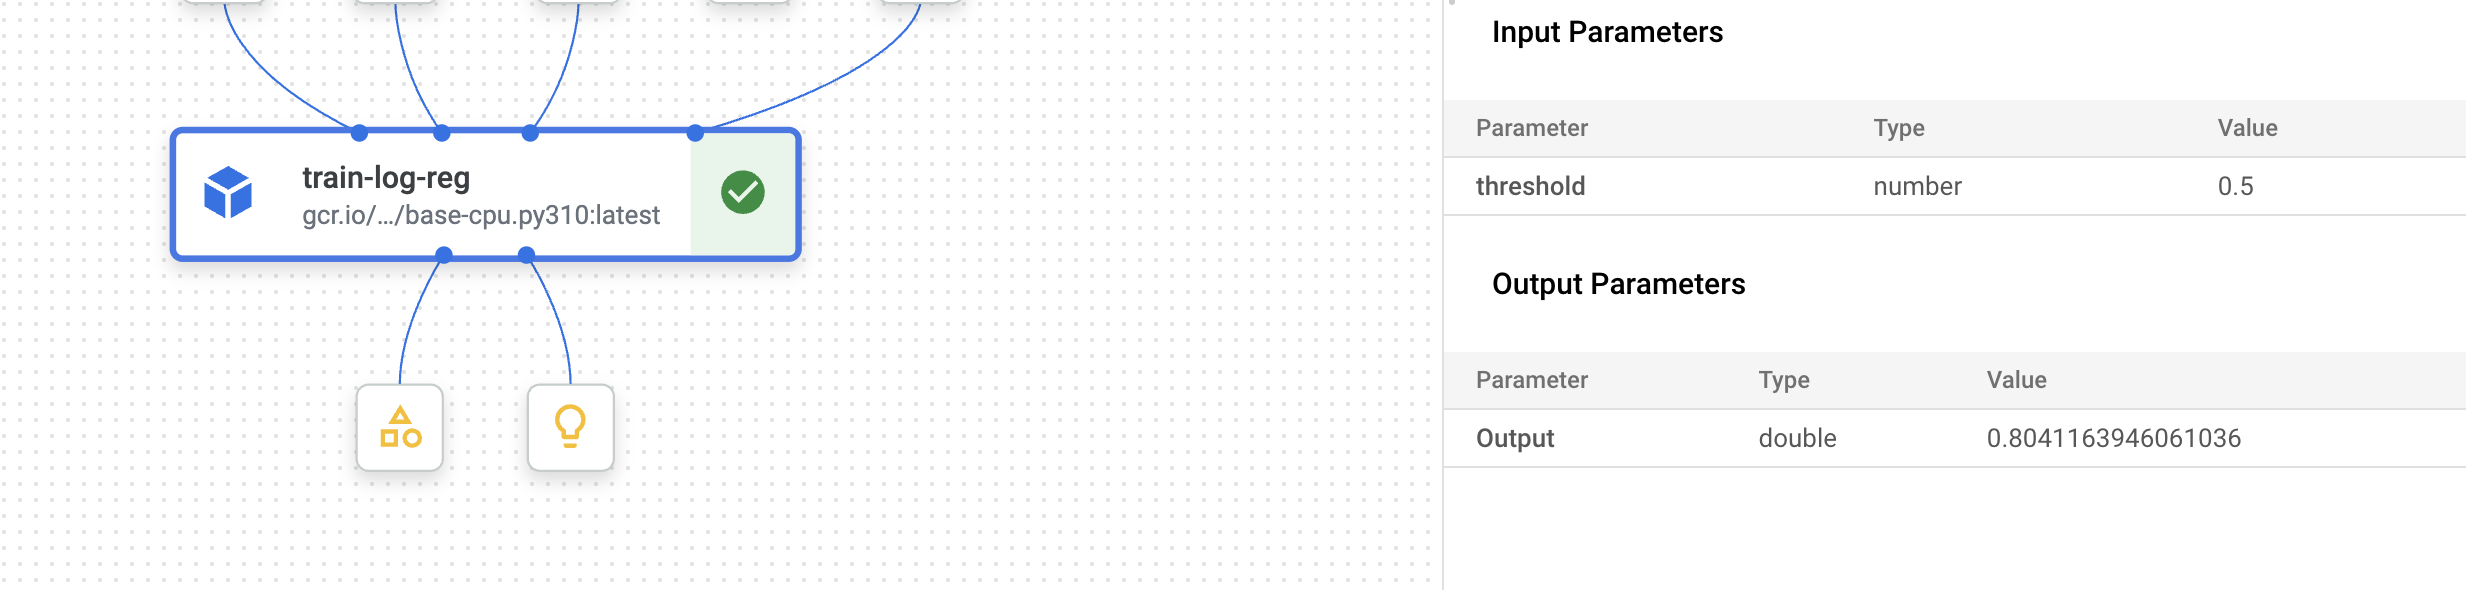

The thing we provide to the pipeline run is (1) the Cloud Storage path to a dataset (in `csv` format), (2) lists with the categorical and numerical variables that will be used to train a model, and (3) the name of the column that will be used as the label. The output is the model, datasets and arrays that generated it, and accuracy as the output parameter.

In [ ]:
# Imports
from kfp.dsl import (
    Input, 
    Output, 
    Dataset,
    Model,
    Artifact, 
    component,
    pipeline,
)

In [ ]:
# Components
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install=[
        "gcp_python_client_functions",
    ],
)
def read_data_gcs(
    project_id: str, 
    data_gcs_uri: str,
    out_df: Output[Dataset], 
):
    import pandas as pd
    import pickle
    
    from gcp_python_client_functions.clients import Storage
    ##################### CODE:
    stg_obj = Storage(project_id)

    df = pd.read_csv(data_gcs_uri)

    # Base formatting:
    df.columns = df.columns.str.lower()
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()

    pd.to_pickle(df, out_df.path + ".pkl")

@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def clean_churn_data(
    in_dataframe: Input[Dataset],
    out_df_prepared: Output[Dataset], 
):
    import pandas as pd
    import numpy as np
    import pickle

    dataframe = pd.read_pickle(in_dataframe.path + ".pkl")  

    df_prepared = dataframe.copy()
    df_prepared.totalcharges = pd.to_numeric(df_prepared.totalcharges, errors='coerce') # coerse: bad non numeric values to NaN
    
    # Handle null values
    df_prepared.totalcharges = df_prepared.totalcharges.fillna(0)

    # Binary label (we'll handle the rest of the variables later):
    df_prepared.churn = (df_prepared.churn == 'yes').astype(int)

    pd.to_pickle(df_prepared, out_df_prepared.path + ".pkl")

@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def split_data(
    in_df: Input[Dataset],
    out_df_train_full: Output[Dataset], 
    out_df_train: Output[Dataset], 
    out_df_val: Output[Dataset], 
    out_df_test: Output[Dataset],
    test_size: float = 0.2,
    validation_size: float = 0.2,
    random_state: int = 1,
):
    import pandas as pd
    import numpy as np
    import pickle

    from sklearn.model_selection import train_test_split

    df = pd.read_pickle(in_df.path + ".pkl") 
    
    df_train_full, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )

    # Obtain validation set from the full train:
    train_size = 1 - test_size
    new_validation_size = validation_size/train_size
    
    df_train, df_val = train_test_split(
        df_train_full, 
        test_size=new_validation_size, 
        random_state=random_state,
    )

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    pd.to_pickle(df_train_full, out_df_train_full.path + ".pkl")
    pd.to_pickle(df_train, out_df_train.path + ".pkl")
    pd.to_pickle(df_val, out_df_val.path + ".pkl")
    pd.to_pickle(df_test, out_df_test.path + ".pkl")


@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def preprocess_data(
    in_dataframe: Input[Dataset],
    cat_features: list,
    num_features: list,
    label: str,
    out_X: Output[Artifact], 
    out_y: Output[Artifact], 
    out_mct: Output[Artifact],
    fit: bool = True,
    in_mct: Input[Artifact] = None,
):
    import pandas as pd 
    import numpy as np
    import pickle

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer

    dataframe = pd.read_pickle(in_dataframe.path + ".pkl") 

    y = dataframe[label]
    dataframe = dataframe[cat_features + num_features].copy()
    
    if fit:
        ohe = OneHotEncoder(
            drop='first', # Whether to drop one of the features
            sparse=False, # Will return sparse matrix if set True
            handle_unknown='error' # Whether to raise an error 
        ) 
        mct = make_column_transformer(
            (ohe, cat_features),
            remainder='passthrough',
        )
        X = mct.fit_transform(dataframe)
    else:
        with open(in_mct.path + '.pkl', 'rb') as f:
            mct = pickle.load(f)
        X = mct.transform(dataframe)

    with open(out_X.path+'.pkl', 'wb') as f:
        pickle.dump(X, f)
    with open(out_y.path+'.pkl', 'wb') as f:
        pickle.dump(y, f)
    with open(out_mct.path+'.pkl', 'wb') as f:
        pickle.dump(mct, f)

@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def train_log_reg(
    in_X_train: Input[Artifact], 
    in_y_train: Input[Artifact],
    in_X_val: Input[Artifact],
    in_y_val: Input[Artifact],
    out_model: Output[Model], 
    out_cm: Output[Artifact],
    threshold: float = 0.5,
) -> float:
    import pandas as pd 
    import numpy as np
    import pickle

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix

    with open(in_X_train.path + '.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open(in_y_train.path + '.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open(in_X_val.path + '.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open(in_y_val.path + '.pkl', 'rb') as f:
        y_val = pickle.load(f)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred_val = model.predict_proba(X_val)[:,1]
    churn_decision_val = (y_pred_val >= threshold)

    val_accuracy = (churn_decision_val == y_val).mean()
    cm = confusion_matrix(churn_decision_val, y_val)

    with open(out_model.path+'.pkl', 'wb') as f:
        pickle.dump(model, f)
    with open(out_cm.path+'.pkl', 'wb') as f:
        pickle.dump(cm, f)

    return val_accuracy

In [ ]:
# Pipeline
@pipeline(
    name="pipeline-log-reg",
)
def pipeline(
    project_id: str, 
    data_gcs_uri: str,
    cat_features: list,
    num_features: list,
    label: str,
):    
    o1 = read_data_gcs(
        project_id = project_id, 
        data_gcs_uri = data_gcs_uri,
    )
    o2 = clean_churn_data(
        in_dataframe = o1.outputs["out_df"],
    )
    o3 = split_data(
        in_df = o2.outputs["out_df_prepared"],
    )
    o4_train = preprocess_data(
        in_dataframe = o3.outputs["out_df_train"],
        cat_features = cat_features,
        num_features = num_features,
        label = label,
    )
    o4_val = preprocess_data(
        in_dataframe = o3.outputs["out_df_val"],
        cat_features = cat_features,
        num_features = num_features,
        label = label,
        fit = False,
        in_mct = o4_train.outputs["out_mct"],
    )

    train_log_reg(
        in_X_train = o4_train.outputs["out_X"],
        in_y_train = o4_train.outputs["out_y"],
        in_X_val = o4_val.outputs["out_X"],
        in_y_val = o4_val.outputs["out_y"],
    )

In [ ]:
# Run pipeline:
import os

from datetime import datetime
import pytz

from kfp import compiler
from google.cloud import aiplatform

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')
TEMPLATE_JSON_PATH_LOCAL="pipeline.json"

tz = pytz.timezone("US/Eastern")
EXECUTION_TS = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
DISPLAY_NAME = "pipeline-log-reg-{}".format(EXECUTION_TS)
PIPELINE_ROOT = "gs://{}/02_churn_prediction/pipeline_root".format(BUCKET_NAME)


# Input parameters:
data_gcs_uri = f"gs://{BUCKET_NAME}/02_churn_prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

numerical = ['tenure', 'monthlycharges']
categorical = [ 'gender',
                'seniorcitizen',
                'partner',
                'dependents',
                'phoneservice',
                'multiplelines',
                'internetservice',
                'onlinesecurity',
                'onlinebackup',
                'deviceprotection',
                'techsupport',
                'streamingtv',
                'streamingmovies',
                'contract',
                'paperlessbilling',
                'paymentmethod',
                ]
label = "churn"

# Compiling:
compiler.Compiler().compile(
        pipeline_func=pipeline, package_path=TEMPLATE_JSON_PATH_LOCAL
)

# Running:
job = aiplatform.PipelineJob(
        display_name=DISPLAY_NAME,
        template_path=TEMPLATE_JSON_PATH_LOCAL,
        pipeline_root=PIPELINE_ROOT,
        enable_caching=True,
        project=PROJECT_ID,
        location=LOCATION,
        labels={"user": USER},
        parameter_values={
            "project_id": PROJECT_ID, 
            "data_gcs_uri": data_gcs_uri,
            "cat_features": categorical,
            "num_features": numerical,
            "label": label,
        },
)

job.submit(service_account=SERVICE_ACCOUNT)

Creating PipelineJob
PipelineJob created. Resource name: projects/532579765435/locations/us-central1/pipelineJobs/pipeline-log-reg-20231002003733
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/532579765435/locations/us-central1/pipelineJobs/pipeline-log-reg-20231002003733')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/pipeline-log-reg-20231002003733?project=532579765435
